# 4 - Modelagem 

Essa parte do processo tem o intuito de treinar modelos de aprendizado de máquina para poder classificar um futuro cliente, se ele vai pagar ou não. Nesse sentido, iremos aplicar alguns modelos de aprendizado de máquina e avaliar suas performances. Além disso, o modelo que tiver a melhor performance passará por uma otimização de hiperparâmetros afim de deixa-lo mais capacitado. Logo depois, subir para o ambiente de produção.

## Modelos

- **RandomForestClassifier** é um modelo de aprendizado supervisionado baseado em um conjunto de árvores de decisão (método ensemble). Ele cria árvores independentes, cada uma treinada com amostras aleatórias do dataset e subconjuntos de variáveis, e depois combina os resultados por meio de votação para fazer a predição final. Esse processo reduz o overfitting típico de uma única árvore e melhora a generalização. Tecnicamente, o Random Forest trabalha com o conceito de bagging (bootstrap aggregating), explorando a variabilidade dos dados e a média das previsões das árvores para reduzir a variância do modelo.

- **XGBClassifier** (Extreme Gradient Boosting) é um modelo de boosting baseado em árvores, que constrói as árvores de forma sequencial. Cada nova árvore é ajustada para corrigir os erros cometidos pelas anteriores, o que torna o modelo altamente eficiente e preciso. Ele utiliza gradiente descendente para otimizar uma função de perda, e sua força está na regularização interna (L1 e L2) e na eficiência computacional, pois faz uso de paralelismo e pode inteligente. Ele é sensível a parâmeetros como learning_rate, max_depth e n_estimators, que controlam o equilíbrio entre viés e variância.

- **LGBMClassifier** (Ligth Gradient Boosting Machine) é uma variação otimizada do Gradient Boosting, projetada para ser ainda mais rápida e eficiente que o XGBoost. Ele utiliza um método de crescimento das árvores chamado leaf-wise (crescimento por folha) em vez do tradicional level-wise, o que permite capturar relações mais complexas nos dados e melhorar a acurácia. Ele também suporta grande volumes de dados, é altamente escalável e utiliza representações binárias eficientes para acelerar o treinamento e reduzir o consumo de memória. O lgbm usa Histogram-based Gradient Boosting, convertendo os valores contínuos em intervalor discretos (bins), o que reduz o custo computacional de busca por divisões ideais nas árvores.

- **KNN** é um modelo baseado em instâncias, não paramétricos, que classificar um novo ponto de dados de acordo com a maioria das classes de seus k-vizinhos mais próximos. Ele usa métricas de distância normalmente se usa a Euclidiana para determinar quais amostras do treinamento estão mais próximas da nova amostra. Ele é um modelo baseado em casos, ou seja, não realiza aprendizado explícito, apenas armazena os dados e faz cálculos no momento da predição, o que o torna simples.

- **LogisticRegression** é um modelo linear de classificação binária que utiliza a função logística (ou sigmoide) para transformar uma combinação linear de variáveis independentes em uma probabilidade entre 0 e 1. A fronteira de decisão é determinada pelos coeficientes das variáveis, que são ajustados para minimizar a função de perda logarítimica (log-loss). Ele assuma uma relação linear entre os preditores e o logaritmo da razão de chances (log-odds) da classe positiva.

- **MLPClassifier** É uma rede neural feedforward composta por camadas de neurônios totalmente conectadas. Cada neurônio aplica uma transformação linear seguida de uma função de ativação não linear (como Relu, tanh. sigmoid). O treinamento é feito atráves do backpropagation utilizando gradiente descendente para ajustar os pesos com base na função de perda


### Local de salvamento das runs do mlflow

In [24]:
import sys
import os

# Caminho da raiz do projeto
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [25]:
from src.utils.paths import experiments_path
from src.utils.paths import data_path
import mlflow
from pathlib import Path

tracking_dir = experiments_path("mlruns").resolve()
tracking_dir.mkdir(parents=True, exist_ok=True)  # Garante que o diretório existe

# Configura o MLflow para usar esse diretório
mlflow.set_tracking_uri(tracking_dir.as_uri())

# Define o experimento
mlflow.set_experiment("Classification_default_experiment")

<Experiment: artifact_location='file:///C:/Users/eduar/OneDrive/Documentos/SandBox/Projetos/risco_ml/experiments/mlruns/585793176030616435', creation_time=1765571340136, experiment_id='585793176030616435', last_update_time=1765571340136, lifecycle_stage='active', name='Classification_default_experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [26]:
print("Tracking URI:", mlflow.get_tracking_uri())

Tracking URI: file:///C:/Users/eduar/OneDrive/Documentos/SandBox/Projetos/Sistema-AvaliacaoRisco-Financeiro/experiments/mlruns


In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import mlflow.lightgbm
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay, recall_score, average_precision_score
import mlflow
from mlflow.tracking import MlflowClient
from IPython.display import Image, display
import optuna
import numpy as np
import shap
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [28]:
csv_file = data_path("dados_novos.csv", "interim")
dados = pd.read_csv(csv_file)

In [29]:
X_train = pd.read_pickle(data_path("X_train.pkl", "processed"))
X_test  = pd.read_pickle(data_path("X_test.pkl",  "processed"))
y_train = pd.read_pickle(data_path("y_train.pkl", "processed"))
y_test  = pd.read_pickle(data_path("y_test.pkl",  "processed"))

### Usando Recursive Feature Elimination

- RFECV é um método de seleção automática de variáveis que combina importãncia de features, eliminação recursiva e validação cruzada para encontrar o  melhor subconjunto de variáveis para um modelo.

A forma intuitiva dessa técnica é: Treinar o modelo e ver quais variáveis menos ajudam na predição, elimina essas variáveis e repetimos o processo, e durante essa fase, é feita a validação cruzada para decidir quantas variáveis manter.

- RFE decide quais features remover
- CV decide quantas features são ideais

Fitting estimator with 11 features.
Fitting estimator with 10 features.

Número ótimo de variáveis: 9
Features selecionadas: ['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership', 'loan_intent', 'loan_grade']


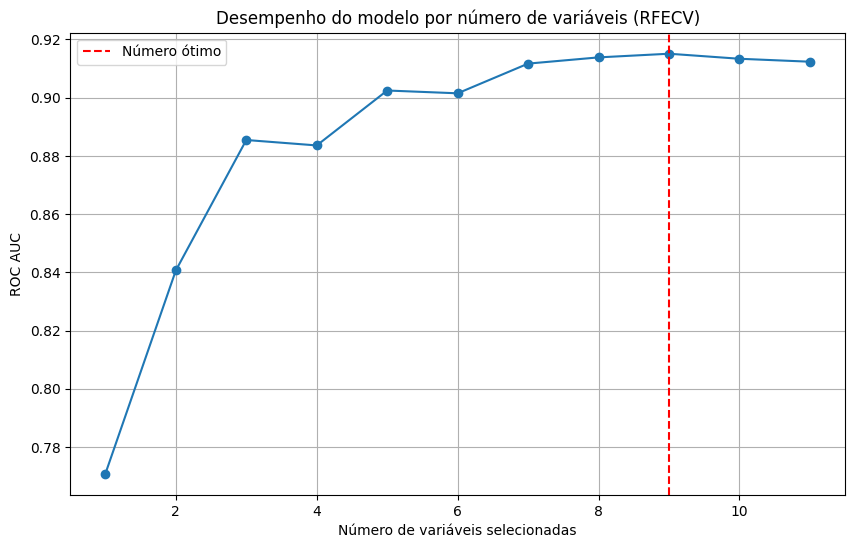

In [30]:
# Modelo base aprimorado
modelo_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


rfecv = RFECV(
    estimator=modelo_rf,
    step=1,
    cv=StratifiedKFold(5),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train, y_train)

print(f"\nNúmero ótimo de variáveis: {rfecv.n_features_}")
features_selecionadas = X_train.columns[rfecv.support_]
print("Features selecionadas:", list(features_selecionadas))

# As pontuações médias por número de features testadas
mean_test_scores = rfecv.cv_results_['mean_test_score']

# Gráfico
plt.figure(figsize=(10,6))
plt.title('Desempenho do modelo por número de variáveis (RFECV)')
plt.xlabel('Número de variáveis selecionadas')
plt.ylabel('ROC AUC')
plt.plot(range(1, len(mean_test_scores) + 1), mean_test_scores, marker='o')
plt.axvline(rfecv.n_features_, color='red', linestyle='--', label='Número ótimo')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
features_selecionadas = X_train.columns[rfecv.support_]
X_train_selecionado = X_train[features_selecionadas]
X_test_selecionado = X_test[features_selecionadas]

print("Variáveis selecionadas:", list(features_selecionadas))
print("X_train_selecionado shape:", X_train_selecionado.shape)
print("X_test_selecionado shape:", X_test_selecionado.shape)

Variáveis selecionadas: ['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership', 'loan_intent', 'loan_grade']
X_train_selecionado shape: (16843, 9)
X_test_selecionado shape: (7219, 9)


In [32]:
import pickle

scalers_dir = data_path("", "scalers")
scalers_dir.mkdir(parents=True, exist_ok=True)

# RFECV já treinado
selected_feature_names = X_train.columns[rfecv.support_].tolist()

feature_selection_artifact = {
    "selected_features": selected_feature_names,
    "n_features": len(selected_feature_names),
}

with open(scalers_dir / "feature_selection.pkl", "wb") as f:
    pickle.dump(feature_selection_artifact, f)

print("Seleção de features do RFECV salva com sucesso")

Seleção de features do RFECV salva com sucesso


## Métricas

- **Matriz de confusão** Ela compara os valores previstos pelo modelo com os valores reais
    - TP (True Positive): Modelo prêve prositivo e é realmente positivo
    - TN (True Negative): Modelo prevê negativo e é realmente negativo
    - FP (False Positive): Modelo prevê positivo, mas é negativo (Falso Alarme)
    - FP (False Negative): Modelo prevê negativo, mas é positivo (erro do modelo)

- **Acurácia** Mede a proporção de acertos sobre o total de previsões

- **Precision** A precisão mede quantos dos positivos previstos pelo modelo são realmente positivos

- **Recall** Mede quantos dos positivos reais o modelo conseguiu capturar

- **F1 Score** É a média harmônica entre precisão e recall

- **ROC_AUC** ROC (Receiver Operating Characteristic): mostra a relação entre True Positive Rate (Recall) e False Positive Rate (FPR) em diferentes limiares. AUC (Area Under Curve): área sob a curva ROC. Varia de 0 a 1



In [33]:
def avalia_modelo(model, X_train_selecionado, y_train, X_test_selecionado, y_test):
    """Treina o modelo e retorna todas métricas de classificação"""
    model.fit(X_train_selecionado, y_train)
    preds = model.predict(X_test_selecionado)
    probs = model.predict_proba(X_test_selecionado)[:,1] if hasattr(model, "predict_proba") else None

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    especificidade = tn / (tn + fp)

    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs) if probs is not None else np.nan,
        "pr_auc": average_precision_score(y_test, probs) if probs is not None else np.nan,
        "specificity": especificidade
    }
    return metrics


def plot_feature_importance_mlflow(model, columns, top_n=9):
    """
    Cria gráfico horizontal de feature importance para modelos que suportam
    ou coeficientes para modelos lineares. Também gera SHAP summary plot se possível.
    """
    try:
        # Tree-based models
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            feat_imp = pd.Series(importances, index=columns)
            top_feat = feat_imp.sort_values(ascending=False).head(top_n)

            fig, ax = plt.subplots(figsize=(10, 6))
            y_pos = np.arange(len(top_feat))
            ax.barh(y_pos, top_feat.values, color="steelblue")
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_feat.index.tolist(), fontsize=12)
            ax.invert_yaxis()  # maior importância em cima

            for i, v in enumerate(top_feat.values):
                ax.text(v + 0.01*v.max(), i, f"{v:.3f}", color='black', va='center', fontsize=10)

            ax.set_xlabel("Importance", fontsize=12)
            ax.set_title(f"Top {top_n} Feature Importances", fontsize=14)
            plt.tight_layout()
            return fig

        # Linear models (Logistic Regression)
        elif hasattr(model, "coef_"):
            coefs = pd.Series(model.coef_[0], index=columns)
            top_coef = coefs.abs().sort_values(ascending=False).head(top_n)

            fig, ax = plt.subplots(figsize=(10, 6))
            y_pos = np.arange(len(top_coef))
            ax.barh(y_pos, top_coef.values, color="coral")
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_coef.index.tolist(), fontsize=12)
            ax.invert_yaxis()

            for i, v in enumerate(top_coef.values):
                ax.text(v + 0.01*v.max(), i, f"{v:.3f}", color='black', va='center', fontsize=10)

            ax.set_xlabel("Coefficient Magnitude", fontsize=12)
            ax.set_title(f"Top {top_n} Coefficients (Linear Model)", fontsize=14)
            plt.tight_layout()
            return fig

        # Se não suportar, tenta gerar SHAP
        else:
            explainer = shap.Explainer(model, columns)
            shap_values = explainer(columns)
            shap.summary_plot(shap_values, columns, show=False)
            fig = plt.gcf()
            plt.close(fig)
            return fig

    except Exception as e:
        print("Erro ao gerar feature importance:", e)
        return None

In [34]:
modelos = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="auc",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",
        metric="minkowski"
    ),

    "LogisticRegression": LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="liblinear",
        max_iter=200,
        random_state=42
    ),

    "MLP": MLPClassifier(
    hidden_layer_sizes=(30,),
    activation="relu",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
    )

}

Queremos pegar o modelo que teve um maior acerto otimizando o pr_auc_scorer

In [35]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

mlflow.set_experiment("Classification_default_experiment")

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
resultados_modelos = {}

for nome, model in modelos.items():
    with mlflow.start_run(run_name=nome):
        # Cross-validation usando ROC AUC como métrica
        cv_scores = cross_val_score(model, X_train_selecionado, y_train, cv=cv, scoring=pr_auc_scorer)
        mlflow.log_metric("cv_roc_auc_mean", cv_scores.mean())
        mlflow.log_metric("cv_roc_auc_std", cv_scores.std())

        # Treina e avalia no conjunto de teste original
        metrics = avalia_modelo(model, X_train_selecionado, y_train, X_test_selecionado, y_test)
        for metrica, valor in metrics.items():
            mlflow.log_metric(metrica, valor)

        resultados_modelos[nome] = metrics

        # Importância das features
        fig = plot_feature_importance_mlflow(model, X_train_selecionado.columns)
        if fig:
            mlflow.log_figure(fig, artifact_file="feature_importance.png")
            plt.close(fig)

        # Log do modelo no MLflow
        mlflow.sklearn.log_model(model, name="model")
        print(f"{nome} finalizado com sucesso!")

2025/12/26 11:49:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest finalizado com sucesso!


2025/12/26 11:49:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost finalizado com sucesso!


2025/12/26 11:50:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM finalizado com sucesso!
Erro ao gerar feature importance: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier()


2025/12/26 11:50:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN finalizado com sucesso!


2025/12/26 11:50:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression finalizado com sucesso!
Erro ao gerar feature importance: The passed model is not callable and cannot be analyzed directly with the given masker! Model: MLPClassifier(early_stopping=True, hidden_layer_sizes=(30,),
              learning_rate_init=0.01, random_state=42)


2025/12/26 11:50:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLP finalizado com sucesso!


In [36]:
melhor_modelo_nome = max(resultados_modelos, key=lambda x: resultados_modelos[x]["pr_auc"])
melhor_modelo_metricas = resultados_modelos[melhor_modelo_nome]

print(f"Melhor modelo: {melhor_modelo_nome}")
print("Métricas do melhor modelo:")
for metrica, valor in melhor_modelo_metricas.items():
    print(f"{metrica}: {valor:.4f}")

Melhor modelo: LightGBM
Métricas do melhor modelo:
accuracy: 0.9320
precision: 0.9466
recall: 0.6994
f1: 0.8045
roc_auc: 0.9367
pr_auc: 0.8800
specificity: 0.9901


### Otimizando o LigthGBM

In [37]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "max_bin": trial.suggest_int("max_bin", 128, 512),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 2.0, 6.0),
        "n_jobs": -1,
        "random_state": 42,
        "verbosity": -1
    }

    model = LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation com PR AUC
    scores = cross_val_score(model, X_train_selecionado, y_train, cv=skf, scoring=pr_auc_scorer)
    return scores.mean()

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)
print(f"Melhor PR AUC: {study.best_value:.5f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Melhor PR AUC: 0.88155


In [38]:
best_params = study.best_params
best_lgb = LGBMClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbose = -1
)

# Treina o modelo
best_lgb.fit(X_train_selecionado, y_train)

# Prepara amostra para SHAP
X_sample_shap = X_train_selecionado.sample(min(100, len(X_train_selecionado)), random_state=42)

with mlflow.start_run(run_name="LightGBM_Final_Best"):

    # Log dos hiperparâmetros
    mlflow.log_params(best_params)

    # Log do modelo no MLflow
    mlflow.sklearn.log_model(
        best_lgb,
        artifact_path="lgb_model",
        registered_model_name="lgb_prob_default",
        input_example=X_train_selecionado.head(5)  # evita warning de input_example
    )

    # Previsões de probabilidade para a classe 1 - Inadimplente
    preds_final = best_lgb.predict_proba(X_test_selecionado)[:, 1]

    # PR-AUC (average precision)
    pr_auc_final = average_precision_score(y_test, preds_final)
    mlflow.log_metric("pr_auc", pr_auc_final)

    # Feature importance em barras
    print("Gerando gráfico de Feature Importance (barras)...")
    try:
        if hasattr(best_lgb, "feature_importances_"):
            importances = best_lgb.feature_importances_
            feat_imp = pd.Series(importances, index=X_train_selecionado.columns)
            top_feat = feat_imp.sort_values(ascending=False).head(9)
            
            fig_bars, ax = plt.subplots(figsize=(10, 6))
            y_pos = np.arange(len(top_feat))
            ax.barh(y_pos, top_feat.values, color="steelblue")
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_feat.index.tolist(), fontsize=12)
            ax.invert_yaxis()

            for i, v in enumerate(top_feat.values):
                ax.text(v + 0.01*v.max(), i, f"{v:.3f}", color='black', va='center', fontsize=10)

            ax.set_xlabel("Importance", fontsize=12)
            ax.set_title(f"Top 9 Feature Importances (LightGBM)", fontsize=14)
            plt.tight_layout()
            mlflow.log_figure(fig_bars, artifact_file="feature_importance_bars.png")
            plt.close(fig_bars)
            print("✓ Feature Importance (barras) salvo")
    except Exception as e:
        print(f"Erro ao gerar feature importance (barras): {e}")

    # SHAP Summary Plot
    print("Gerando SHAP Summary Plot...")
    try:
        explainer = shap.TreeExplainer(best_lgb)
        shap_values = explainer.shap_values(X_sample_shap)

        # Para modelos de classificação binária, pega os valores da classe positiva
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Classe positiva ou seja, deu default

        # Cria o summary plot
        fig_shap = plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample_shap, feature_names=X_train_selecionado.columns.tolist(), 
                         max_display=9, show=False)
        plt.tight_layout()
        mlflow.log_figure(fig_shap, artifact_file="shap_summary_plot.png")
        plt.close(fig_shap)
        print("✓ SHAP Summary Plot salvo")
    except Exception as e:
        print(f"Erro ao gerar SHAP plot: {e}")

    # Feature importance original (mantém compatibilidade)
    try:
        fig = plot_feature_importance_mlflow(best_lgb, X_train_selecionado.columns)
        if fig:
            mlflow.log_figure(fig, artifact_file="feature_importance.png")
            plt.close(fig)
    except Exception as e:
        print(f"Erro ao gerar feature importance original: {e}")

print("Modelo LightGBM final, feature importance (barras e SHAP) e métricas logadas no MLflow com sucesso")

2025/12/26 11:54:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Registered model 'lgb_prob_default' already exists. Creating a new version of this model...
Created version '6' of model 'lgb_prob_default'.


Gerando gráfico de Feature Importance (barras)...
✓ Feature Importance (barras) salvo
Gerando SHAP Summary Plot...
✓ SHAP Summary Plot salvo
Modelo LightGBM final, feature importance (barras e SHAP) e métricas logadas no MLflow com sucesso


### Calculando o threshold

É o valor dew corte usado para transformar a probabilidade prevista pelo modelo em uma classe binária. O threshold foi definido buscando maximizar a estatística KS (Kolmogorov-Smirnov), que mede a diferença máxima entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR).

- Testar varios limites de 0.01 até 0.99
- Para cada limiar, transformar as probabilidades em 0 e 1.
- Calcular TPR e FPR
- Calcular kS = TPR-FPR
- Escolher o limiar que gera o maior valor de KS, pois ele indica o ponto em que o modelo melhorar separa as classes


O ponto de corte é definido com base na performance do modelo para maximizar a separação entre positivos e negativos, tornando a classificação mais confiável.

Melhor KS: 0.735 no Threshold: 0.420


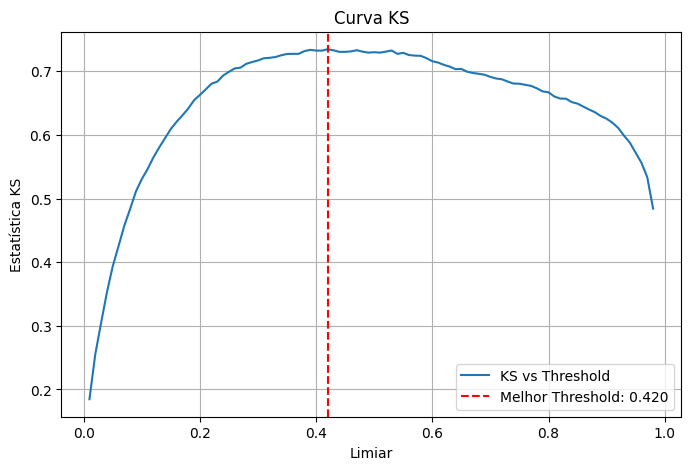

In [39]:
def encontrar_melhor_threshold_ks(y_real, prob_pred, passo=0.01):
    limiares = np.arange(0.01, 0.99, passo)
    valores_ks = []

    for t in limiares:
        pred = (prob_pred >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_real, pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        ks = tpr - fpr
        valores_ks.append(ks)

    valores_ks = np.array(valores_ks)
    indice_melhor = np.argmax(valores_ks)
    melhor_threshold = limiares[indice_melhor]
    melhor_ks = valores_ks[indice_melhor]

    return melhor_threshold, melhor_ks, limiares, valores_ks


probabilidades_pred = best_lgb.predict_proba(X_test_selecionado)[:, 1]
melhor_threshold, melhor_ks, limiares, valores_ks = encontrar_melhor_threshold_ks(y_test, probabilidades_pred)

print(f"Melhor KS: {melhor_ks:.3f} no Threshold: {melhor_threshold:.3f}")

plt.figure(figsize=(8,5))
plt.plot(limiares, valores_ks, label='KS vs Threshold')
plt.axvline(melhor_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {melhor_threshold:.3f}')
plt.xlabel('Limiar')
plt.ylabel('Estatística KS')
plt.title('Curva KS')
plt.legend()
plt.grid()
plt.show()

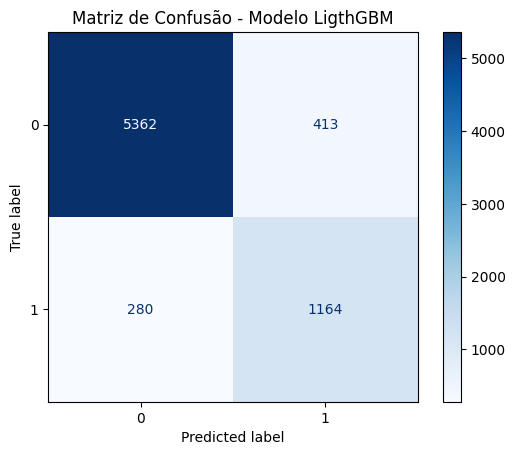

In [40]:
y_pred_bin = (preds_final >= 0.420).astype(int)
cm = confusion_matrix(y_test, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Modelo LigthGBM")
plt.show()

**Análise**

A matriz de confusão mostra que o modelo ainda gera alguns falsos positivos e negativos, mas a razaão de acertos x erros indica que ele é robusto e útil para decisões de crédito e mitigação de risco.

In [41]:
# Função para gerar feature importance em barras
def plot_feature_importance_bars(model, feature_names, top_n=9):
    """Gera gráfico de barras horizontal com feature importance"""
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=feature_names)
        top_feat = feat_imp.sort_values(ascending=False).head(top_n)

        fig, ax = plt.subplots(figsize=(10, 6))
        y_pos = np.arange(len(top_feat))
        ax.barh(y_pos, top_feat.values, color="steelblue")
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_feat.index.tolist(), fontsize=12)
        ax.invert_yaxis()

        for i, v in enumerate(top_feat.values):
            ax.text(v + 0.01*v.max(), i, f"{v:.3f}", color='black', va='center', fontsize=10)

        ax.set_xlabel("Importance", fontsize=12)
        ax.set_title(f"Top {top_n} Feature Importances (LightGBM)", fontsize=14)
        plt.tight_layout()
        return fig
    return None

# Função para gerar SHAP summary plot (com cores)
def plot_shap_summary(model, X_sample, feature_names, max_display=9):
    """Gera SHAP summary plot com cores"""
    try:
        # Usa TreeExplainer para modelos baseados em árvore (mais rápido)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)

        # Para modelos de classificação binária, pega os valores da classe positiva
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Classe positiva

        # Cria o summary plot
        fig = plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                         max_display=max_display, show=False)
        plt.tight_layout()
        return fig
    except Exception as e:
        print(f"Erro ao gerar SHAP plot: {e}")
        return None


In [42]:
# Define o experimento no MLflow (usado para organizar os runs)
mlflow.set_experiment("Classification_CreditScore")

# Cliente do MLflow para operações no Model Registry
client = MlflowClient()

# Nome oficial do modelo no registry (padrão do projeto)
model_name = "lgb_prob_default"


# -------------------------------------------------------
# Preparação de dados auxiliares para interpretabilidade
# -------------------------------------------------------

X_sample_shap = X_train_selecionado.sample(
    min(100, len(X_train_selecionado)),
    random_state=42
)

# -------------------------------------------------------
# Início do run principal - modelo pronto para produção
# -------------------------------------------------------

with mlflow.start_run(run_name="LightGBM_Production_Ready") as run:
    run_id = run.info.run_id

    # -----------------------------------
    # Registro de hiperparâmetros e tuning
    # -----------------------------------

    mlflow.log_params(best_params)
    mlflow.log_param("threshold_optimal", melhor_threshold)
    mlflow.log_param("best_ks", melhor_ks)

    # -----------------------------------
    # Avaliação final do modelo
    # -----------------------------------

    preds_final = best_lgb.predict_proba(X_test_selecionado)[:, 1]
    metrics_final = avalia_modelo(
        best_lgb,
        X_train_selecionado, y_train,
        X_test_selecionado, y_test
    )

    # Log das métricas de teste
    for metrica, valor in metrics_final.items():
        mlflow.log_metric(f"test_{metrica}", valor)

    # Log explícito de métricas críticas de negócio
    mlflow.log_metric("optimal_threshold", melhor_threshold)
    mlflow.log_metric("best_ks_score", melhor_ks)


    # -----------------------------------
    # Feature Importance (visual)
    # -----------------------------------

    print("Iniciando geração do gráfico de Feature Importance...")
    fig_bars = plot_feature_importance_bars(
        best_lgb,
        X_train_selecionado.columns
    )

    if fig_bars:
        mlflow.log_figure(
            fig_bars,
            artifact_file="feature_importance_bars.png"
        )
        plt.close(fig_bars)
        print("Gráfico de Feature Importance salvo com sucesso.")


    # -----------------------------------
    # SHAP Summary Plot (explicabilidade)
    # -----------------------------------

    print("Gerando SHAP Summary Plot para interpretação global do modelo...")
    fig_shap = plot_shap_summary(
        best_lgb,
        X_sample_shap,
        X_train_selecionado.columns.tolist()
    )

    if fig_shap:
        mlflow.log_figure(
            fig_shap,
            artifact_file="shap_summary_plot.png"
        )
        plt.close(fig_shap)
        print("SHAP Summary Plot registrado no MLflow.")


    # -----------------------------------
    # Salvamento da configuração de features
    # -----------------------------------

    # Armazena as features finais e o threshold utilizado
    features_list = list(X_train_selecionado.columns)

    features_dict = {
        "features": features_list,
        "n_features": len(features_list),
        "threshold": float(melhor_threshold)
    }

    import json
    with open("features_config.json", "w") as f:
        json.dump(features_dict, f, indent=2)

    mlflow.log_artifact(
        "features_config.json",
        
    )

    import os
    os.remove("features_config.json")

    print("Configuração de features salva e versionada.")


    # -----------------------------------
    # Registro do modelo no MLflow
    # -----------------------------------

    # Removendo artifact_path para salvar diretamente em artifacts/
    # Isso evita problemas com estrutura de diretórios aninhada
    mlflow.lightgbm.log_model(
        best_lgb,
        registered_model_name=model_name,
        input_example=X_train_selecionado.head(5)
    )

    print("Modelo registrado no MLflow Model Registry.")


    # -----------------------------------
    # Tags de controle e governança
    # -----------------------------------

    mlflow.set_tag("model_status", "PRODUCTION")
    mlflow.set_tag("model_type", "LightGBM_Production")
    mlflow.set_tag("deployment_ready", "true")
    mlflow.set_tag("production_model", "true")
    mlflow.set_tag("model_version", "production_v1")

    print("Tags de produção aplicadas ao run.")


    # -----------------------------------
    # Configuração automática do alias Production
    # -----------------------------------

    print("\nIniciando configuração do alias 'Production' no Model Registry...")

    try:
        import time
        time.sleep(1)

        all_versions = client.search_model_versions(
            f"name='{model_name}'"
        )

        if all_versions:
            # Seleciona a versão mais recente registrada
            latest_version = sorted(
                all_versions,
                key=lambda x: int(x.version),
                reverse=True
            )[0]

            version_num = latest_version.version

            # Remove alias Production de versões anteriores
            for v in all_versions:
                try:
                    if hasattr(v, "aliases") and v.aliases and "Production" in v.aliases:
                        client.delete_registered_model_alias(
                            model_name,
                            "Production"
                        )
                        print(f"Alias 'Production' removido da versão {v.version}.")
                except:
                    pass

            # Aplica alias Production na versão atual
            client.set_registered_model_alias(
                name=model_name,
                alias="Production",
                version=version_num
            )

            print(f"Alias 'Production' configurado para a versão {version_num}.")
            print("Modelo oficialmente marcado como PRODUÇÃO.")
            print(f"Referência de carregamento: models:/{model_name}@Production")

        else:
            print("Não foi possível localizar versões do modelo para configurar o alias.")

    except Exception as e:
        print("Não foi possível configurar o alias automaticamente.")
        print(f"Detalhes do erro: {e}")
        print("A configuração pode ser feita manualmente no MLflow UI.")


    # -----------------------------------
    # Informações adicionais para deploy
    # -----------------------------------

    deploy_info = {
        "model_name": model_name,
        "model_type": "LightGBM",
        "features": features_list,
        "threshold": float(melhor_threshold),
        "metrics": {k: float(v) for k, v in metrics_final.items()},
        "hyperparameters": {
            k: float(v) if isinstance(v, (int, float)) else str(v)
            for k, v in best_params.items()
        }
    }

    with open("deploy_info.json", "w") as f:
        json.dump(deploy_info, f, indent=2)

    mlflow.log_artifact(
        "deploy_info.json",
        
    )

    os.remove("deploy_info.json")

    print("Informações de deploy salvas e versionadas.")


    # -----------------------------------
    # Resumo final do processo
    # -----------------------------------

    print("\n" + "=" * 60)
    print("Modelo preparado com sucesso para ambiente de produção.")
    print(f"Run ID: {run_id}")
    print(f"Modelo registrado: {model_name}")
    print("=" * 60)


Iniciando geração do gráfico de Feature Importance...
Gráfico de Feature Importance salvo com sucesso.
Gerando SHAP Summary Plot para interpretação global do modelo...
SHAP Summary Plot registrado no MLflow.
Configuração de features salva e versionada.


Registered model 'lgb_prob_default' already exists. Creating a new version of this model...
Created version '7' of model 'lgb_prob_default'.


Modelo registrado no MLflow Model Registry.
Tags de produção aplicadas ao run.

Iniciando configuração do alias 'Production' no Model Registry...
Alias 'Production' removido da versão 5.
Alias 'Production' configurado para a versão 7.
Modelo oficialmente marcado como PRODUÇÃO.
Referência de carregamento: models:/lgb_prob_default@Production
Informações de deploy salvas e versionadas.

Modelo preparado com sucesso para ambiente de produção.
Run ID: d437ccf680a1420789814857c1977a5f
Modelo registrado: lgb_prob_default


In [43]:
import traceback
from mlflow.tracking import MlflowClient
import mlflow.pyfunc

# Nome do artefato
artifact_name = "lgb_prob_default"
client = MlflowClient()

print("="*70)
print(f"VERIFICAÇÃO DO ARTEFATO EM PRODUÇÃO: {artifact_name}")
print("="*70)

try:
    # Busca todas as versões do artefato
    all_versions = client.search_model_versions(f"name='{artifact_name}'")

    if not all_versions:
        print(f"Artefato '{artifact_name}' não encontrado.")
    else:
        print(f"Artefato encontrado! Total de versões: {len(all_versions)}\n")

        # Busca versão marcada como Production
        production_version = None
        for v in all_versions:
            aliases = getattr(v, "aliases", []) or []
            if "Production" in aliases:
                production_version = v
                break

        # Se não encontrar, usa versão mais recente
        if not production_version:
            production_version = sorted(all_versions, key=lambda x: int(x.version), reverse=True)[0]

        aliases = getattr(production_version, "aliases", []) or []
        current_stage = getattr(production_version, "current_stage", None)
        status = getattr(production_version, "status", "UNKNOWN")
        is_production = "Production" in aliases or current_stage == "Production"

        print("="*70)
        print("ARTEFATO CONFIGURADO PARA PRODUÇÃO" if is_production else "ARTEFATO NÃO ESTÁ EM PRODUÇÃO")
        print("="*70)
        print(f"Informações:")
        print(f"  Nome: {artifact_name}")
        print(f"  Versão: {production_version.version}")
        print(f"  Status: {status}")
        print(f"  Aliases: {aliases if aliases else 'Nenhum'}")
        print(f"  Stage: {current_stage or 'None'}")
        print(f"  Run ID: {production_version.run_id}")

        # Lista artefatos disponíveis
        run_id = production_version.run_id
        print("\nArtefatos disponíveis:")
        try:
            artifacts = client.list_artifacts(run_id)
            if not artifacts:
                print("  Nenhum artefato encontrado")
            else:
                def print_artifacts(path, level=0):
                    items = client.list_artifacts(run_id, path)
                    for item in items:
                        indent = "   " * level
                        if item.is_dir:
                            print(f"{indent}{item.path}/")
                            print_artifacts(item.path, level + 1)
                        else:
                            print(f"{indent}{item.path}")
                print_artifacts("")
        except Exception as e:
            print(f"  Erro ao listar artefatos: {e}")

        # Testa carregamento do artefato
        print("\nTestando carregamento do artefato:")
        try:
            if is_production:
                loaded = mlflow.pyfunc.load_model(f'models:/{artifact_name}@Production')
            else:
                loaded = mlflow.pyfunc.load_model(f'models:/{artifact_name}/{production_version.version}')
            print(f"Carregado com sucesso. Tipo: {type(loaded)}")
        except Exception as e:
            print(f"Erro ao carregar artefato: {e}")

    print("\n" + "="*70)

except Exception as e:
    print(f"Erro ao buscar artefato: {e}")
    traceback.print_exc()

VERIFICAÇÃO DO ARTEFATO EM PRODUÇÃO: lgb_prob_default
Artefato encontrado! Total de versões: 7

ARTEFATO CONFIGURADO PARA PRODUÇÃO
Informações:
  Nome: lgb_prob_default
  Versão: 7
  Status: READY
  Aliases: ['Production']
  Stage: None
  Run ID: d437ccf680a1420789814857c1977a5f

Artefatos disponíveis:
deploy_info.json
feature_importance_bars.png
features_config.json
shap_summary_plot.png

Testando carregamento do artefato:
Carregado com sucesso. Tipo: <class 'mlflow.pyfunc.PyFuncModel'>

